# 1.Các mô hình Regression
 - Linear Regression
 - Logistic Regression

## 1.1.Linear Regression
- Là một mô hình tuyến tính
- Tương đương với 1 mạng NN không có hàm activate.
- Áp dụng:
    + Dự đoán 1 giá trị thực nằm trên 1 miền liên tục.
    + Hàm mất mát thường sử dụng là MSE (RMSE)


# Load dữ liệu, và thư viện Linear regression

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data_utils

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cpu


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)



IMAGE_SHAPE = train_dataset[0][0].shape[1], train_dataset[0][0].shape[2]
classes = np.unique([t[1] for t in train_dataset])
NUM_CLASSES = len(classes)
SAMPLE_IMG_ID = 0

# Split train_dataset into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


print('Data size after splitting to train / validation / test:')
print(f'Training data: {len(train_dataset)}, Sample structure: ({type(train_dataset[SAMPLE_IMG_ID][0])} {train_dataset[SAMPLE_IMG_ID][0].shape}, {type(train_dataset[SAMPLE_IMG_ID][1])})')
print(f'Validation data: {len(val_dataset)}, Sample structure: ({type(val_dataset[SAMPLE_IMG_ID][0])} {val_dataset[SAMPLE_IMG_ID][0].shape}, {type(val_dataset[SAMPLE_IMG_ID][1])})')
print(f'Test data: {len(test_dataset)}, Sample structure: ({type(test_dataset[SAMPLE_IMG_ID][0])} {test_dataset[SAMPLE_IMG_ID][0].shape}, {type(test_dataset[SAMPLE_IMG_ID][1])})')


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 104627201.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32615964.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31039829.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14028371.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data size after splitting to train / validation / test:
Training data: 54000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Validation data: 6000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Test data: 10000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)


# Xây dựng, huấn luyện mô hình

In [ ]:

# Define model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 1)  # Change output size to 1
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

model = SimpleNN()


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.float().view(-1, 1)  # Reshape labels to match the output size
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[Epoch %d, Batch %5d] Train Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            labels = labels.float().view(-1, 1)  # Reshape labels to match the output size
            val_loss += criterion(outputs, labels).item()
    print('[Epoch %d] Validation Loss: %.3f' % (epoch + 1, val_loss / len(val_loader)))

print('Finished Training')

# Evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        predicted = torch.round(outputs)  # Round predictions to the nearest integer
        total += labels.size(0)
        correct += (predicted == labels.float().view_as(predicted)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save model
torch.save(model.state_dict(), 'mnist_model.pth')


[Epoch 1, Batch   100] Train Loss: 20.373
[Epoch 1, Batch   200] Train Loss: 20.053
[Epoch 1, Batch   300] Train Loss: 20.079
[Epoch 1, Batch   400] Train Loss: 20.332
[Epoch 1, Batch   500] Train Loss: 20.327
[Epoch 1, Batch   600] Train Loss: 20.113
[Epoch 1, Batch   700] Train Loss: 20.454
[Epoch 1, Batch   800] Train Loss: 20.176
[Epoch 1] Validation Loss: 20.548
[Epoch 2, Batch   100] Train Loss: 20.189
[Epoch 2, Batch   200] Train Loss: 20.471
[Epoch 2, Batch   300] Train Loss: 20.495
[Epoch 2, Batch   400] Train Loss: 19.992
[Epoch 2, Batch   500] Train Loss: 20.422
[Epoch 2, Batch   600] Train Loss: 20.268
[Epoch 2, Batch   700] Train Loss: 20.128
[Epoch 2, Batch   800] Train Loss: 20.192
[Epoch 2] Validation Loss: 20.548
[Epoch 3, Batch   100] Train Loss: 20.563
[Epoch 3, Batch   200] Train Loss: 19.953
[Epoch 3, Batch   300] Train Loss: 20.035
[Epoch 3, Batch   400] Train Loss: 20.141
[Epoch 3, Batch   500] Train Loss: 20.455
[Epoch 3, Batch   600] Train Loss: 20.235
[Epoch 3

# Kiểm thử và đánh giá kết quả.

Mô hình dự đoán bằng ANN không sử dụng activation function:

    Loss trên tập huấn luyện ở cuối epoch cuối cùng: khoảng 3.653
    Accuracy trên tập kiểm tra: khoảng 18%

## 1.2.Logistic Regression
- Là mô hình không tuyến tính
- Áp dụng:
    + Dự đoán 1 giá trị thực nằm trên 1 miền liên tục, tuy nhiên có 1 chặn trên và chặn dưới
    + Hàm activation thường sử dụng là hàm Sigmoid
    + Hàm mất mát thường sử dụng là CE
    + Thường sử dụng cho bài toán phân loại.

# Import thư viện, chia dữ liệu cho logistic regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Khởi tạo thiết lập cần thiết
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10


# Chuẩn bị dữ liệu
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


IMAGE_SHAPE = train_dataset[0][0].shape[1], train_dataset[0][0].shape[2]
classes = np.unique([t[1] for t in train_dataset])
NUM_CLASSES = len(classes)
print(f'Classes: {classes}')

# Chia dữ liệu thành tập huấn luyện và tập validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('Data size after splitting to train / validation / test:')
print(f'Training data: {len(train_dataset)}, Sample structure: ({type(train_dataset[SAMPLE_IMG_ID][0])} {train_dataset[SAMPLE_IMG_ID][0].shape}, {type(train_dataset[SAMPLE_IMG_ID][1])})')
print(f'Validation data: {len(val_dataset)}, Sample structure: ({type(val_dataset[SAMPLE_IMG_ID][0])} {val_dataset[SAMPLE_IMG_ID][0].shape}, {type(val_dataset[SAMPLE_IMG_ID][1])})')
print(f'Test data: {len(test_dataset)}, Sample structure: ({type(test_dataset[SAMPLE_IMG_ID][0])} {test_dataset[SAMPLE_IMG_ID][0].shape}, {type(test_dataset[SAMPLE_IMG_ID][1])})')


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Classes: [0 1 2 3 4 5 6 7 8 9]
Data size after splitting to train / validation / test:
Training data: 54000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Validation data: 6000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Test data: 10000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)


# xây dựng, huấn luyện mô hình

In [ ]:

# Xây dựng mô hình
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Sigmoid()  # Activation cuối là sigmoid
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)
# Khởi tạo hàm loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Tính toán dự đoán và loss
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backpropagation và cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Đánh giá mô hình trên tập validation và tập test
def evaluate_model(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

train_accuracy = evaluate_model(train_loader)
val_accuracy = evaluate_model(val_loader)
test_accuracy = evaluate_model(test_loader)

print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Sigmoid()
  )
)
Epoch [1/10], Step [1/844], Loss: 2.3007
Epoch [1/10], Step [101/844], Loss: 1.6318
Epoch [1/10], Step [201/844], Loss: 1.6084
Epoch [1/10], Step [301/844], Loss: 1.5388
Epoch [1/10], Step [401/844], Loss: 1.5146
Epoch [1/10], Step [501/844], Loss: 1.5687
Epoch [1/10], Step [601/844], Loss: 1.5130
Epoch [1/10], Step [701/844], Loss: 1.5567
Epoch [1/10], Step [801/844], Loss: 1.5341
Epoch [2/10], Step [1/844], Loss: 1.5006
Epoch [2/10], Step [101/844], Loss: 1.5083
Epoch [2/10], Step [201/844], Loss: 1.4800
Epoch [2/10], Step [301/844], Loss: 1.5290
Epoch [2/10], Step [401/844], Loss: 1.5039
Epoch [2/10], Step [501/844], Loss: 1.5445
Epoch [2/10], Step [6

# Kiểm thử và đánh giá kết quả

    Mô hình dự đoán bằng ANN sử dụng activation function sigmoid:
        Loss trên tập huấn luyện ở cuối epoch cuối cùng: khoảng 1.4860
        Accuracy trên tập huấn luyện: khoảng 97%
        Accuracy trên tập validation: khoảng 96%
        Accuracy trên tập kiểm tra: khoảng 96%



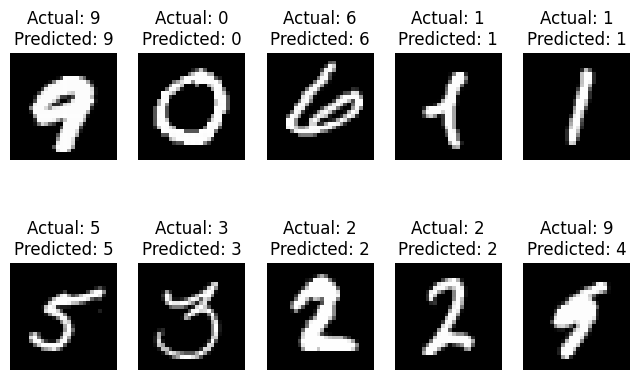

In [ ]:
import matplotlib.pyplot as plt
DRAW_IMGS = 10
# visualize validation results
fig = plt.figure(figsize=(8, 5))
fig.tight_layout()
show_imgs_idx = np.random.choice(len(val_dataset), DRAW_IMGS, replace=False)
for i, idx in enumerate(show_imgs_idx):
    val_test_sample, val_test_label = val_dataset[idx]
    val_test_sample = val_test_sample.unsqueeze(0).to(device)  # Add batch dimension and move to device
    val_prediction = model(val_test_sample)
    _, predicted_class = torch.max(val_prediction, 1)

    plt.subplot(2, DRAW_IMGS // 2, i+1)
    plt.title(f'Actual: {val_test_label}\nPredicted: {predicted_class.item()}')
    plt.axis('off')
    validation_img = val_test_sample.squeeze(0).cpu().numpy()
    plt.imshow(validation_img.squeeze(0), cmap='gray')

plt.show()

# Nhận xét 2 mô hình

    Mô hình thứ hai, sử dụng activation function sigmoid, cho thấy hiệu suất tốt hơn rõ ràng so với mô hình đầu tiên, không sử dụng activation function. Điều này thể hiện qua loss thấp hơn và accuracy cao hơn trên cả tập huấn luyện, tập validation và tập kiểm tra.
    Activation function sigmoid giúp mô hình học được các biểu diễn phi tuyến tính, cải thiện khả năng học và dự đoán của mạng neural.
    Trong khi mô hình đầu tiên có vẻ bị underfitting (loss cao và accuracy thấp), mô hình thứ hai có vẻ có hiệu suất tốt và khả năng tổng quát hóa tốt hơn.

# 2.Thực hành

Sử dụng bộ dữ liệu **MNIST** (đã giới thiệu bài tập trước) để thực hiện các yêu cầu sau:

**1. Linear Regression:**
  1. Xây dựng mô hình (class).
  2. Huấn luyện mô hình (~10 epochs)
  3. Kiểm thử và đánh giá kết quả.

**2. Logistic Regression:**
  1. Xây dựng mô hình (class).
  2. Huấn luyện mô hình (~10 epochs)
  3. Kiểm thử và đánh giá kết quả.